In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

e1 = a*b + c
a += h
e2 = a*b + c

print('d1', e1)
print('d2', e2)
print('slope de/da', (e2 - e1)/h)

d1 4.0
d2 3.999699999999999
slope de/da -3.000000000010772


In [11]:
# data structures to build NN
class Value:
    def __init__(self,data, _children=(),_op='',label=''):
        # _children indicates which values were used to arrive at output value
        # _op indicates which operation was used on input values to arrive at output value
        self.data = data
        self.grad = 0.0 #dL/DValue, default no effect on L
        self._backward = lambda : None # default function doesnt do anything
        self._prev=set(_children)
        self._op=_op
        self.label=label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        #other is also a value object, if not
        other=other if isinstance(other,Value) else Value(other)
        # __ methods to define operator for objects
        out=Value(self.data+other.data, (self,other),'+')
        # children of out self and value
        def _backward():
            self.grad+=1.0*out.grad
            other.grad+=1.0*out.grad
        out._backward=_backward
        return out
    
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data, (self,other),'*')
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out

    #if mul doesnt work ex 2*a (2.__mul__(a)) perform rmul
    def __rmul__(self,other):
        return self*other

    def __pow__(self,other):
        assert isinstance(other,(int,float)) #only support int or float powers
        out=Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward=_backward
        return out
        
    def __truediv__(self,other):
        return self*other**-1

    def __neg__(self):
        return self*-1

    def __sub__(self,other):
        return self+(-other)

    def exp(self):
        x=self.data
        out=Value(math.exp(x), (self,),'exp')
        def _backward():
            self.grad += out.data*out.grad
        out._backward=_backward
        return out
    
    def tanh(self):
        x=self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        #takes only one input hence only has one child
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out
    
    def backward(self):
        # topological sort is laying out of graph such that such that edges go from left to right
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev: #iterate through children
                    build_topo(child)
                topo.append(v) #add root node to list after all children have been processed
                #go from nodes left to right, recursively we reach left node and then start to build back up
        build_topo(self)
        self.grad= 1.0
        for node in reversed(topo):
            node._backward()
    
        #because we have gradient info from last node, hence we reverse 
        #the topological order to make sure that before calculating gradient of children 
        #we have gradient of parent


## Testing Operations on Values Class

In [12]:
a=Value(2.0,label='a')
b = Value(4.0,label='b')
a-b

Value(data=-2.0)

In [13]:
a=Value(2.0,label='a')
b=Value(-3.0,label='b')
c=Value(10,label='c')
#print(a+b) # python internally calls a.__add__(b)
e= a*b; e.label='e'
d=e + c; d.label='d'
f=Value(-2.0,label='f')
L=d*f; L.label='L'
print(e._prev)
print(e._op)
print(e)
print(d._prev)
print(d._op)
print(d)
# keeping expression graphs (what values produce what other values)

{Value(data=2.0), Value(data=-3.0)}
*
Value(data=-6.0)
{Value(data=10), Value(data=-6.0)}
+
Value(data=4.0)


# Implementing Forward and Backward Pass (Single Neuron)

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#o = n.tanh(); 
e=(2*n).exp()
o=(e-1)/(e+1)
o.label = 'o'

In [15]:
o.backward()

In [17]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f| grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

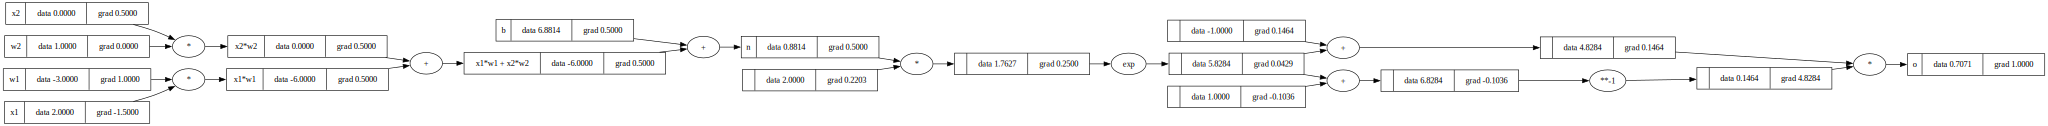

In [18]:
draw_dot(o)

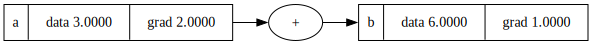

In [19]:
#bug: we are overwriting the gradient of a, instead add up gradients +=
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

# Creating MLP and Backpropagating

In [20]:
class Neuron:
    #nin: number of inputs to neuron
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))
    def __call__(self,x):
        # w*x+b
        # sum is initialized with 0 if you try to add custom obj to int it will give error
        # hence initialized with b
        act=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    # take 2 values as inputs and return 3 outputs (one from each neuron)
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        #each neuron takes input 2d input x and produces 1d act
        outs=[n(x) for n in self.neurons] # nout dim output
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self,nin,nouts):
        #nouts corresponds to list of neurons present in each layer
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [21]:
x=[2.0,3.0,-1]
mlp= MLP(3,[4,4,1])
o=mlp(x)

In [22]:
len(mlp.parameters())

41

In [23]:
# dummy dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [24]:
def train(mlp,epochs):
    # Forward Pass and loss calculation
    for epoch in range(epochs):
        ypred= [mlp(x) for x in xs]
        loss=sum([(yout-ygt)**2 for ygt,yout in zip(ys,ypred)],Value(0.0))

        # dont forget to zero out gradients before each backward pass
        for p in mlp.parameters():
            p.grad=0
        loss.backward()
    
        #Backward Pass and Parameter Update
        loss.backward()
        # gradient: direction of steepest ascent, but we want to minimize the loss (output)
        for p in mlp.parameters():
            p.data+= -0.01*p.grad
            
        print(f'epoch: {epochs}, loss: {loss}')
    return mlp

In [25]:
trained_mlp=train(mlp,epochs=10)

epoch: 10, loss: Value(data=7.353544555802277)
epoch: 10, loss: Value(data=6.161617657585962)
epoch: 10, loss: Value(data=4.803833085105486)
epoch: 10, loss: Value(data=4.403281617581339)
epoch: 10, loss: Value(data=0.6054515949384278)
epoch: 10, loss: Value(data=0.11791380941797291)
epoch: 10, loss: Value(data=0.03586762704765174)
epoch: 10, loss: Value(data=0.03027319479192405)
epoch: 10, loss: Value(data=0.02625410834331193)
epoch: 10, loss: Value(data=0.02320473564611262)


In [26]:
ypred=[trained_mlp(x) for x in xs]
list((ypred,yout) for ypred,yout in zip(ypred,ys))

[(Value(data=0.9397169182034094), 1.0),
 (Value(data=-0.8916428084373866), -1.0),
 (Value(data=-0.9346963830393858), -1.0),
 (Value(data=0.9658814719223328), 1.0)]

In [27]:
ypred= [mlp(x) for x in xs]
loss=sum([(yout-ygt)**2 for ygt,yout in zip(ys,ypred)],Value(0.0))
loss

Value(data=0.0208039672605565)